In [42]:
import csv
import json
import os
import time

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
from geopandas import GeoDataFrame
from geopy.exc import GeocoderServiceError, GeocoderTimedOut
from geopy.geocoders import Nominatim
from matplotlib.lines import Line2D
from shapely.geometry import Point

ox.settings.log_console = False
ox.settings.use_cache = True

In [80]:
LHR_NAME_STR = "Lahore District, Pakistan"
LHR_LAT = 31.456845
LHR_LON = 74.407836

CITYLINES_SRCS = [
    (
        "https://www.citylines.co/api/lahore/raw_source/sections",
        "lahore_sections.geojson",
    ),
    (
        "https://www.citylines.co/api/lahore/raw_source/stations",
        "lahore_stations.geojson",
    ),
    (
        "https://www.citylines.co/api/data/lahore/lines_systems_and_modes",
        "lahore_lines_systems_and_modes.json",
    ),
]

OSMNX_DATA_DIR = "../data/osmnx"
SPEEDO_DATA_DIR = "../data/speedo"
CITYLINES_DATA_DIR = "../data/citylines"

os.makedirs(OSMNX_DATA_DIR, exist_ok=True)
os.makedirs(SPEEDO_DATA_DIR, exist_ok=True)
os.makedirs(CITYLINES_DATA_DIR, exist_ok=True)

## Worlpop Data Preparation


In [44]:
def fetch_worldpop_data(url: str, data_dir: str) -> str:
    os.makedirs(data_dir, exist_ok=True)

    zip_fname = url.split("/")[-1]
    zip_fpath = os.path.join(data_dir, zip_fname)
    csv_fname = zip_fname.replace(".zip", ".csv")
    csv_fpath = os.path.join(data_dir, csv_fname)

    # Download if missing
    if not os.path.exists(zip_fpath):
        print(f"Downloading {zip_fname}...")

        import requests

        resp = requests.get(url, stream=True)
        resp.raise_for_status()

        with open(zip_fpath, "wb") as f:  # binary mode
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

        print(f"Saved -> {zip_fpath}")
    else:
        print(f"{zip_fname} already exists. Skipping download.")

    # Unzip if needed
    if not os.path.exists(csv_fpath):
        print(f"Extracting {csv_fname}...")

        import zipfile

        with zipfile.ZipFile(zip_fpath, "r") as archive:
            archive.extractall(data_dir)

        print(f"Extracted to {data_dir}")
    else:
        print(f"{csv_fname} already exists. Skipping extraction.")

    return csv_fpath


worldpop_url = (
    "https://data.worldpop.org/GIS/Population_Density/"
    "Global_2000_2020_1km_UNadj/2020/PAK/pak_pd_2020_1km_UNadj_ASCII_XYZ.zip"
)

WORLDPOP_DIR = "../data/worldpop"
WORLDPOP_CSV_FPATH = fetch_worldpop_data(worldpop_url, WORLDPOP_DIR)

print("WorldPop CSV ready at:", WORLDPOP_CSV_FPATH)

pak_pd_2020_1km_UNadj_ASCII_XYZ.zip already exists. Skipping download.
pak_pd_2020_1km_UNadj_ASCII_XYZ.csv already exists. Skipping extraction.
WorldPop CSV ready at: ../data/worldpop/pak_pd_2020_1km_UNadj_ASCII_XYZ.csv


#### Lahore Boundary Setup


In [45]:
lhr_boundary: GeoDataFrame = ox.geocode_to_gdf(
    LHR_NAME_STR
)  # Get administrative Boundary for Lahore


lhr_cntr_gdf: GeoDataFrame = (
    gpd.GeoDataFrame(  # create gdf w/ single point i.e Lahore's center
        {"geometry": [Point(LHR_LON, LHR_LAT)]},
        crs="EPSG:4326",  # WGS84
    )
)

lhr_cntr_gdf_utm = ox.projection.project_gdf(
    lhr_cntr_gdf
)  # Ensure Lahore's gdf is in the UTM CRS

##### Extract UTM CRS for future use


In [46]:
utm_crs = lhr_cntr_gdf_utm.crs
print("UTM CRS:", utm_crs)

if utm_crs is None:
    raise TypeError("`utm_crs` is none.")

lhr_boundary = lhr_boundary.to_crs(utm_crs)  # Ensure boundary is in UTM CRS

UTM CRS: EPSG:32643


#### Plot Lahore's Boundary


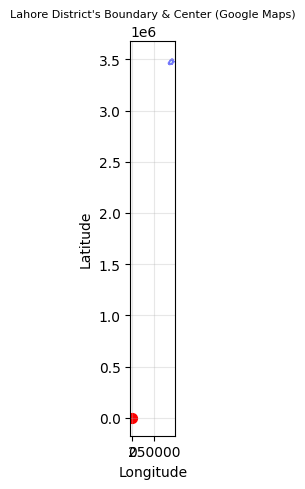

In [68]:
fig, ax = plt.subplots(figsize=(6, 5))

lhr_boundary.plot(
    ax=ax, color="lightblue", edgecolor="blue", alpha=0.5, label="Lahore District"
)
lhr_cntr_gdf.plot(ax=ax, color="red", markersize=50)

ax.set_title(
    "Lahore District's Boundary & Center (Google Maps)",
    fontsize=8,
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Get Lahore's points of interest via OMSNX

In [69]:
pois = ox.features_from_place(
    LHR_NAME_STR,
    {
        "amenity": ["hospital", "university", "college"],
        "shop": ["supermarket", "mall"],
        "building": ["retail", "commercial"],
    },
)

pois.head(3)

geometry addr:city  \
element id                                               
node    271105745   POINT (74.3715 31.47673)    Lahore   
        272381690  POINT (74.34562 31.55025)       NaN   
        300856816  POINT (74.34611 31.52423)    Lahore   

                              addr:street   amenity emergency healthcare  \
element id                                                                 
node    271105745        St 29 Sec W Ph 3  hospital       yes   hospital   
        272381690                     NaN   college       NaN        NaN   
        300856816  Main Boulevard Gulberg       NaN       NaN        NaN   

                                           name addr:postcode opening_hours  \
element id                                                                    
node    271105745  DHA Medical Center Phase III           NaN           NaN   
        272381690             Aitchison College           NaN           NaN   
        300856816           Main Market Gulberg         54000    9am : 11pm   

                   shop  ... addr:full owner parking parking:capacity  \
element id               ...                                            
node    271105745   NaN  ...       NaN   NaN     NaN              NaN   
        272381690   NaN  ...       NaN   NaN     NaN              NaN   
        300856816  mall  ...       NaN   NaN     NaN              NaN   

                  building:ownership capacity:persons ramp:wheelchair  \
element id                                                              
node    271105745                NaN              NaN             NaN   
        272381690                NaN              NaN             NaN   
        300856816                NaN              NaN             NaN   

                  building:architecture year_of_construction postal_code  
element id                                                                
node    271105745                   NaN                  NaN         NaN  
        272381690                   NaN                  NaN         NaN  
        300856816                   NaN                  NaN         NaN  

[3 rows x 127 columns]

#### Feature engineering and Data Preparation (POIs)

Keep only the points of interest relevant to us, w/ all unnecessary columns removed.


In [49]:
def filter_pois(df, conditions):
    return df[conditions][["geometry", "name"]].copy()


hospitals = filter_pois(pois, pois["amenity"] == "hospital").assign(type="hospital")
universities = filter_pois(
    pois, pois["amenity"].isin(["university", "college"])
).assign(type="education")
markets = filter_pois(
    pois,
    pois["shop"].isin(["supermarket", "mall"])
    | pois["building"].isin(["retail", "commercial"]),
).assign(type="market")

all_pois = gpd.GeoDataFrame(
    gpd.pd.concat([hospitals, universities, markets]), crs=pois.crs
)

pois = None

# Retain only the center of polygon/multipolygon for each point of interest
all_pois.geometry = all_pois.geometry.apply(
    lambda geom: (
        geom.centroid if geom.geom_type in ["Polygon", "MultiPolygon"] else geom
    )
)

if utm_crs is None:
    raise TypeError("`utm_crs` is none.")

all_pois = all_pois.to_crs(utm_crs)
all_pois.to_file(f"{OSMNX_DATA_DIR}/all-pois.gpkg", layer="pois", driver="GPKG")
all_pois.head(3)

geometry  \
element id                                          
node    271105745  POINT (440299.449 3482608.993)   
        526681507  POINT (434629.628 3485496.606)   
        563684371  POINT (437375.331 3486167.245)   

                                           name      type  
element id                                                 
node    271105745  DHA Medical Center Phase III  hospital  
        526681507              PU Health Center  hospital  
        563684371         یونائیٹڈ کرسچن ہسپتال  hospital

#### Generate Graph of Road Network inside Lahore's Boundary


In [ ]:
if os.path.exists(f"{OSMNX_DATA_DIR}/network.graphml"):
    print("Found Lahore's graph. Loading.")
    lhr_graph = ox.load_graphml(f"{OSMNX_DATA_DIR}/network.graphml")
else:
    print("Graph not found. Computing...")
    lhr_graph = ox.graph_from_polygon(  # downloads
        lhr_boundary.geometry.iloc[0], network_type="drive", truncate_by_edge=True  # type: ignore
    )

    lhr_graph = ox.project_graph(lhr_graph, to_crs=utm_crs)
    ox.save_graphml(lhr_graph, filepath=f"{OSMNX_DATA_DIR}/network.graphml")

Found Lahore's graph. Loading.


In [ ]:
nodes, edges = ox.graph_to_gdfs(lhr_graph)
major_roads: GeoDataFrame = edges[
    edges["highway"].isin(["primary", "secondary", "trunk"])
]

major_roads.head(3)

,,,osmid,highway,lanes,maxspeed,name,oneway,reversed,length,geometry,tunnel,bridge,ref,access,junction,width
u,v,key,,,,,,,,,,,,,,,
59634015,8146995886,0,177946605,trunk,4,70,West Canal Bank Road,True,False,292.907737,"LINESTRING (431533.146 3483055.318, 431589.857...",NaN,NaN,NaN,NaN,NaN,NaN
8146995886,652438327,0,177946605,trunk,4,70,West Canal Bank Road,True,False,218.942848,"LINESTRING (431801.553 3483172.57, 431854.242 ...",NaN,NaN,NaN,NaN,NaN,NaN
59634249,59635978,0,177946605,trunk,4,70,West Canal Bank Road,True,False,209.427602,"LINESTRING (432374.204 3483474.119, 432550.859...",NaN,NaN,NaN,NaN,NaN,NaN


### Visualization


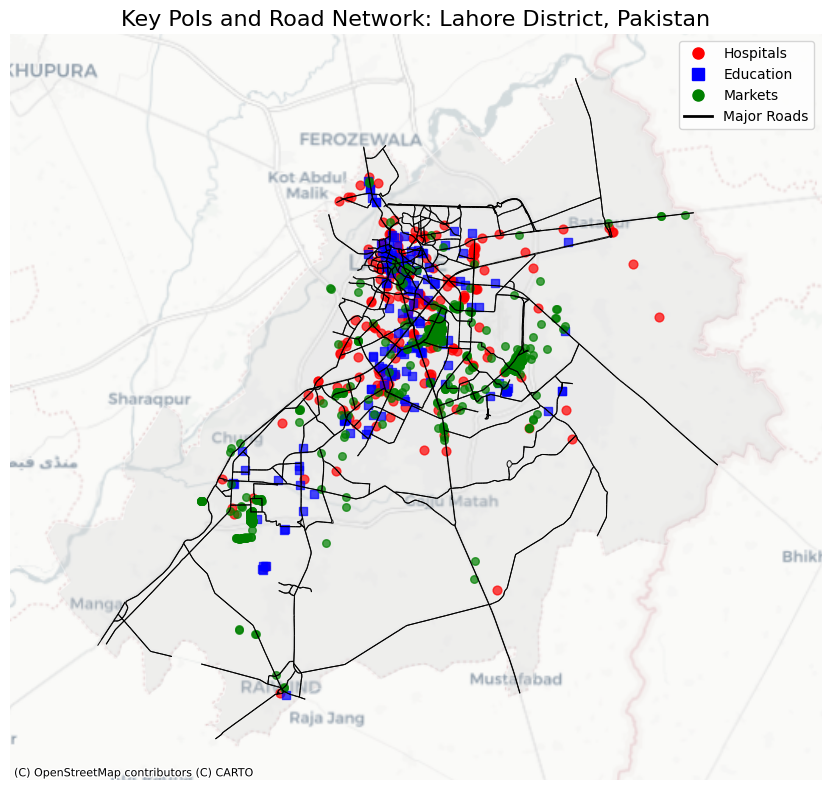

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))

lhr_boundary.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.3)
major_roads.plot(ax=ax, color="black", linewidth=0.7)

poi_colors = {"hospital": "red", "education": "blue", "market": "green"}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois["type"] == ptype]
    subset.plot(
        ax=ax,
        color=color,
        markersize=30 + 10 * (ptype == "hospital"),
        alpha=0.7,
        marker="o" if ptype != "education" else "s",
    )

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)  # type: ignore

legend_elements = [
    Line2D([0], [0], color="red", lw=0, marker="o", markersize=8, label="Hospitals"),
    Line2D([0], [0], color="blue", lw=0, marker="s", markersize=8, label="Education"),
    Line2D([0], [0], color="green", lw=0, marker="o", markersize=8, label="Markets"),
    Line2D([0], [0], color="black", lw=2, label="Major Roads"),
]
ax.legend(handles=legend_elements, loc="upper right")
ax.set_title(f"Key PoIs and Road Network: {LHR_NAME_STR}", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{OSMNX_DATA_DIR}/lahore-poi-network.png", dpi=300)
plt.show()

## Points of Interest + Graph Interpretation


In [56]:
print(f"Hospitals: {len(hospitals)}")
print(f"Education Institutions: {len(universities)}")
print(f"Markets: {len(markets)}")
print(f"Total POIs: {len(all_pois)}")
print()
print(f"Road Network: {len(edges)} edges")
print(f"Number of nodes: {len(lhr_graph.nodes)}")

Hospitals: 227
Education Institutions: 160
Markets: 804
Total POIs: 1191

Road Network: 378090 edges
Number of nodes: 145131


## Discard Unnecessary Population Info Rows


In [75]:
CLIPPED_GPKG = f"{WORLDPOP_DIR}/worldpop_lahore_rows.gpkg"

if os.path.exists(CLIPPED_GPKG):
    print("Loading existing Lahore population density file.")
    lahore_pop_gdf = gpd.read_file(CLIPPED_GPKG)
else:
    print("Generating Lahore's population density in particular.")
    pk_pop_df = pd.read_csv(WORLDPOP_CSV_FPATH)

    pk_pop_gdf = gpd.GeoDataFrame(
        pk_pop_df,
        geometry=gpd.points_from_xy(pk_pop_df.X, pk_pop_df.Y),
        crs="EPSG:4326",  # for some godforsaken reason, using lhr_boundary.crs doesn't work here...
    )

    if not lhr_boundary.crs:
        raise RuntimeError("`boundary.crs` was None")

    pk_pop_gdf = pk_pop_gdf.to_crs(lhr_boundary.crs)
    lahore_pop_gdf = gpd.clip(pk_pop_gdf, lhr_boundary)
    lahore_pop_gdf = lahore_pop_gdf[lahore_pop_gdf["Z"] > 0]

    if len(lahore_pop_gdf) > 0:
        lahore_pop_gdf.to_file(CLIPPED_GPKG, driver="GPKG")
        print(f"Saved clipped data to {CLIPPED_GPKG}")
    else:
        print("Warning: No valid population data found in Lahore boundary.")


if not utm_crs:
    raise RuntimeError("`utm_crs` was None")

lahore_pop_gdf = lahore_pop_gdf.to_crs(utm_crs)

Loading existing Lahore population density file.


In [76]:
lahore_pop_gdf = lahore_pop_gdf.rename(
    columns={"X": "longitude", "Y": "latitude", "Z": "population"}
)

lahore_pop_gdf.head(3)

,longitude,latitude,population,geometry
0,74.202916,31.212083,746.548706,POINT (424073.354 3453380.183)
1,74.194583,31.212083,612.143555,POINT (423279.534 3453385.936)
2,74.186250,31.212083,733.004272,POINT (422485.712 3453391.749)


## Prepare CityLines Data

Namely the Metro + Orange Line.


In [ ]:
def download_json(url: str, fname: str, save_dir: str):
    fpath = os.path.join(save_dir, fname)

    if os.path.exists(fpath):
        print(f"{fname} already exists. Skipping download.")
        return fpath

    print(f"Downloading {fname}...")
    import requests

    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(fpath, "w", encoding="utf-8") as f:
            f.write(response.text)
        print(f"Saved {fname} to {fpath}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {fname}: {e}")
        return None

    return fpath


for url, fname in CITYLINES_SRCS:
    download_json(url, fname, CITYLINES_DATA_DIR)

lahore_sections.geojson already exists. Skipping download.
lahore_stations.geojson already exists. Skipping download.
lahore_lines_systems_and_modes.json already exists. Skipping download.


## Downloading and Saving Speedo routes and Stations


In [ ]:
GEOJSON_PATH = os.path.join(SPEEDO_DATA_DIR, "speedo_sections.geojson")

geolocator = Nominatim(user_agent="naqsha-e-safar-speedo-converter")

from speedo_routes import SPEEDO_ROUTES


def geocode_location(location_name: str):
    """Return [lon, lat] for a stop, or [None, None] if it fails."""
    query = f"{location_name}, Lahore, Pakistan"
    try:
        time.sleep(0.4)
        loc = geolocator.geocode(query, timeout=5)
        if loc:
            return [loc.longitude, loc.latitude]  # type: ignore
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"   Geocoding error for '{location_name}': {e}")
        return [None, None]
    time.sleep(0.5)
    print(f"  Could not geocode '{location_name}'")
    return [None, None]


def create_route_feature(route_name, route_data, route_id):
    """Build a single GeoJSON Feature for a route."""
    print(f"\n Processing {route_name}...")
    coordinates = []

    for stop in route_data["stops"]:
        print(f"   {stop}")
        lon, lat = geocode_location(stop)
        if lon is not None and lat is not None:
            coordinates.append([lon, lat])

    if len(coordinates) < 2:
        print(f"   Not enough coordinates for {route_name}, skipping")
        return None

    length = len(coordinates) * 500  # rough estimate

    return {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coordinates,
        },
        "properties": {
            "id": route_id,
            "klass": "Section",
            "length": length,
            "opening": 2013,
            "lines": [
                {
                    "line": route_name,
                    "line_url_name": f"speedo-{route_name.lower().replace(' ', '-')}",
                    "system": "Lahore Speedo Bus",
                }
            ],
        },
    }


def write_geojson():
    features = []
    route_id = 30000

    for route_name, route_data in SPEEDO_ROUTES.items():
        feature = create_route_feature(route_name, route_data, route_id)
        if feature:
            features.append(feature)
            route_id += 1

    collection = {"type": "FeatureCollection", "features": features}
    with open(GEOJSON_PATH, "w", encoding="utf-8") as f:
        json.dump(collection, f, indent=2, ensure_ascii=False)

    print(f"\n GeoJSON written to {GEOJSON_PATH}")
    print(f" Total routes: {len(features)}")


if not os.path.exists(SPEEDO_DATA_DIR):
    print("Generating Speedo GeoJSON for naqsha-e-safar")
    write_geojson()
else:
    print("Speedo route data found. Skipping geocoding.")

Generating Speedo GeoJSON for naqsha-e-safar

 Processing Route 1...
   Railway Station
   Ek Moriya
  Could not geocode 'Ek Moriya'
   Nawaz Sharif Hospital
   Kashmiri Gate
   Lari Adda
   Azadi Chowk
   Texali Chowk
  Could not geocode 'Texali Chowk'
   Bhatti Chowk

 Processing Route 2...
   Samanabad Morr
   Corporation Chowk
   Taj Company
   Sanda
   Double Sarkan
  Could not geocode 'Double Sarkan'
   Moon Market
   Ganda Nala
   Bhatti Chowk

 Processing Route 3...
   Railway Station
   Ek Moriya
  Could not geocode 'Ek Moriya'
   Nawaz Sharif Hospital
   Kashmiri Gate
   Lari Adda
   Azadi Chowk
   Timber Market
   METRO
   Niazi Chowk
   Shahdara Metro Station
  Could not geocode 'Shahdara Metro Station'
   Shahdara Lari Adda
  Could not geocode 'Shahdara Lari Adda'

 Processing Route 4...
   R.A Bazar
   Nadeem Chowk
  Could not geocode 'Nadeem Chowk'
   Defence Morr
  Could not geocode 'Defence Morr'
   Shareef Market
  Could not geocode 'Shareef Market'
   Walton
   Qainc

FileNotFoundError: [Errno 2] No such file or directory: '../data/speedo/speedo_sections.geojson'

## Graph Aggregation


#### Integrate Metro Routes


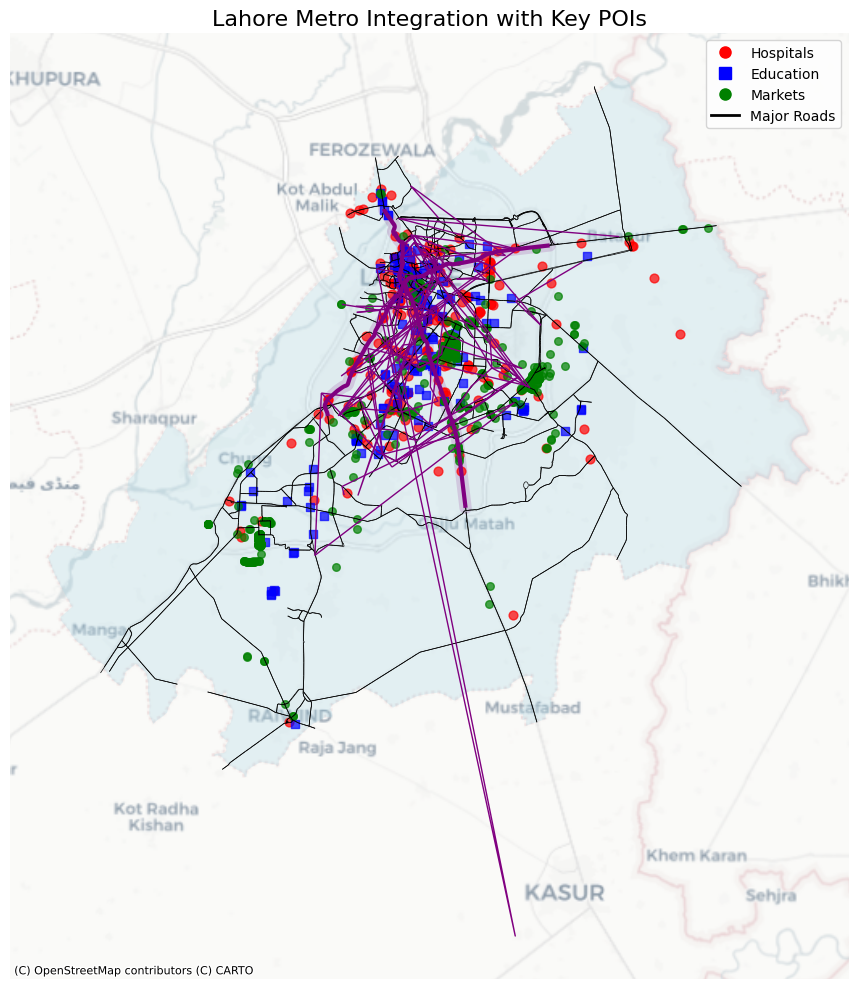

In [ ]:
if utm_crs is None:
    raise TypeError("`utm_crs` is None")

metro_routes = gpd.read_file(f"{CITYLINES_DATA_DIR}/lahore_sections.geojson").to_crs(utm_crs)
metro_service_areas = gpd.GeoDataFrame(geometry=metro_routes.buffer(500), crs=utm_crs)
speedo_routes = gpd.read_file(f"{SPEEDO_DATA_DIR}/speedo_sections.geojson").to_crs(
    utm_crs
)
speedo_service_areas = gpd.GeoDataFrame(geometry=speedo_routes.buffer(500), crs=utm_crs)
fig, ax = plt.subplots(figsize=(12, 10))

lhr_boundary.plot(ax=ax, color="lightblue", alpha=0.3)
major_roads.plot(ax=ax, color="black", linewidth=0.5)

metro_routes.plot(ax=ax, color="purple", linewidth=3, label="Metro Routes")
metro_service_areas.plot(ax=ax, color="purple", alpha=0.15, label="500m Service Area")

speedo_routes.plot(ax=ax, color="purple", linewidth=1, label="Speedo_Routes")


poi_colors = {"hospital": "red", "education": "blue", "market": "green"}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois["type"] == ptype]
    subset.plot(
        ax=ax,
        color=color,
        markersize=30 + 10 * (ptype == "hospital"),
        alpha=0.7,
        marker="o" if ptype != "education" else "s",
    )
ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color="red", lw=0, marker="o", markersize=8, label="Hospitals"),
    Line2D([0], [0], color="blue", lw=0, marker="s", markersize=8, label="Education"),
    Line2D([0], [0], color="green", lw=0, marker="o", markersize=8, label="Markets"),
    Line2D([0], [0], color="black", lw=2, label="Major Roads"),
]
ax.legend(handles=legend_elements, loc="upper right")
ax.set_title("Lahore Metro Integration with Key POIs", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{OSMNX_DATA_DIR}/metro_integration.png", dpi=300, bbox_inches="tight")
plt.show()